Loading and Merging

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

Loading preprocessed data:

In [19]:
# loading only SHARE data X and y
X = pd.read_csv('data/X_SHARE.csv')
y = pd.read_csv('data/y_SHARE.csv')


In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76822 entries, 0 to 76821
Columns: 103 entries, age to co007__4. Easily
dtypes: bool(87), float64(16)
memory usage: 15.8 MB



EDA label variable

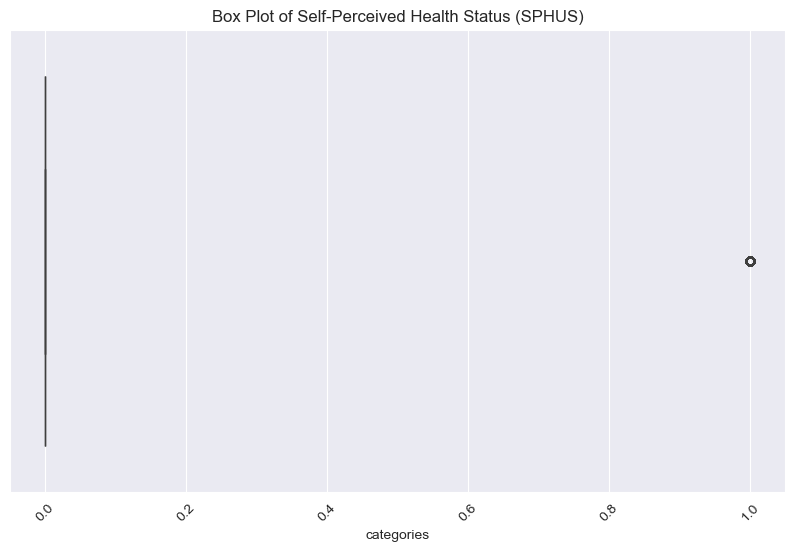

In [21]:
# box plot - doesn't make sense to do boxplot??
plt.figure(figsize=(10, 6))
sns.boxplot(x=y['sphus'])
plt.title('Box Plot of Self-Perceived Health Status (SPHUS)')
plt.xlabel('categories')
plt.xticks(rotation=45)
plt.show()

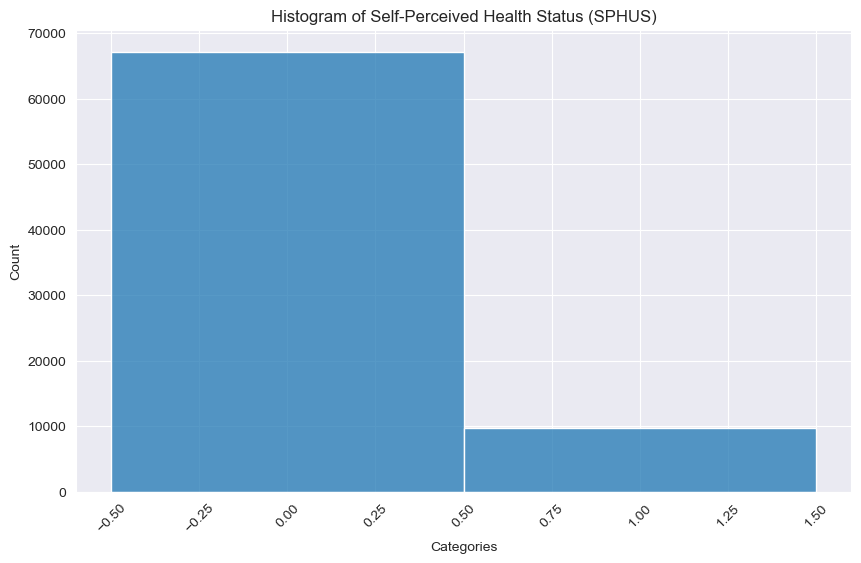

In [22]:
# histo
plt.figure(figsize=(10, 6))
sns.histplot(y['sphus'], discrete=True)
plt.title('Histogram of Self-Perceived Health Status (SPHUS)')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.show()

Grouped Feature Selection

Split the data

In [23]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Imputing categorical with most frequent and doing one hot encoding:

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)

# Dictionary to store the top three most important features by group
best_features = {}

# Iterate over each feature group to identify the top three important features
for group_name, features in feature_groups.items():
    # Ensure the feature group is not empty and contains valid features
    if not features:
        continue
    
    # Select the current group's features from the scaled training data
    valid_features = X_train.columns.intersection(features)

    if valid_features.empty:
        print(f"{group_name}: No valid features after data preparation.")
        continue

    # Train the Random Forest model on the selected features
    rf_model.fit(X_train[valid_features], y_train)

    # Get the feature importances and find the three most important ones
    importances = rf_model.feature_importances_
    top_three_indices = np.argsort(importances)[-3:]  # Get indices of the top three features
    top_three_features = valid_features[top_three_indices]
    best_features[group_name] = top_three_features

    # Optionally, evaluate the model's performance on the test data
    predictions = rf_model.predict(X_test[valid_features])
    accuracy = accuracy_score(y_test, predictions)
    print(f"{group_name} - Top 3 Important Features: {top_three_features.tolist()}, Accuracy: {accuracy:.4f}")

# Output the best features from each group
print("Best Features by Group:", best_features)


Best Features by Group: {}


In [25]:
# Step 1: Flatten the list of best features and convert to a set for faster lookup
best_features_set = set(feature for feature_list in best_features.values() for feature in feature_list)

# Step 2: Initialize a list to hold variables to drop
vars_to_drop = []

# Step 3: Identify variables to drop from each feature group
for group_name, features in feature_groups.items():
    vars_to_drop.extend([var for var in features if var not in best_features_set])

# Step 4: Drop these unwanted variables from the scaled DataFrames
X_train_selected = X_train.drop(columns=vars_to_drop, errors='ignore')
X_test_selected = X_test.drop(columns=vars_to_drop, errors='ignore')

# Step 5: Output the shape of original and modified DataFrames to check consistency
print("Original X_train shape:", X_train.shape)
print("Modified X_train shape:", X_train_selected.shape)
print("Original X_test shape:", X_test.shape)
print("Modified X_test shape:", X_test_selected.shape)


Original X_train shape: (61457, 103)
Modified X_train shape: (61457, 103)
Original X_test shape: (15365, 103)
Modified X_test shape: (15365, 103)


In [26]:
#logisitic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=100000)

# Train the model on the selected features
log_reg_model.fit(X_train_selected, y_train)

# Make predictions on the test data
predictions = log_reg_model.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Model Accuracy: 0.9015


In [27]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

model = LogisticRegression()
param_grid = {
    'C': [0.1],
    'penalty': ['l2', 'elasticnet'],  # l2 seems to have better accuracy
    'max_iter': [100000],
    'solver': ['lbfgs', 'saga'],  # Include 'saga' solver
    'l1_ratio': [0.1, 0.5, 1]  # l1_ratio is needed for elasticnet
}
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
y_pred = grid_search.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/pytho

Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best score: 0.9035748763914493
Logistic Regression Model Accuracy: 0.9015


In [28]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     13393
           1       0.68      0.43      0.53      1972

    accuracy                           0.90     15365
   macro avg       0.80      0.70      0.74     15365
weighted avg       0.89      0.90      0.89     15365


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a new RandomForestClassifier
rf_top_grouped = RandomForestClassifier(random_state=42)

# Fit the RandomForest model on the selected and scaled training data
rf_top_grouped.fit(X_test_selected, y_train)

# Get the parameters of the fitted RandomForestClassifier instance
rf_grouped_parameters = rf_top_grouped.get_params()

# Display each parameter and its value
print("Parameters of the RandomForestClassifier:")
for param, value in rf_grouped_parameters.items():
    print(f"The parameter '{param}' is set to {value}.")

ValueError: Found input variables with inconsistent numbers of samples: [15365, 61457]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10, 50],  # Simplified for speed
    'max_depth': [None, 5, 10],   # Reduced options
    'min_samples_split': [2, 4],  # Default and one variation
}

rf = RandomForestClassifier(random_state=42)

cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)  

try:
    cv_rf.fit(X_train_selected, y_train)  
except Exception as e:
    print("Error during GridSearchCV fitting:", e)  

try:
    y_pred = cv_rf.predict(X_test_selected) 
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
except Exception as e:
    print("Error during prediction:", e)  